In [3]:
from os import listdir
from os.path import isfile, join
# from shapely.geometry import *
# from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

### Look at classification

#### Finding tiles with geolocation_qual < 4096 (CAN SKIP)

In [4]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths='/nas/cee-water/cjgleason/SWOTdata/one_off_randos_v2_0/SWOT_L2_HR_PIXC_020_024_034R_20240821T113904_20240821T113915_PIC0_01.nc',
                            group = 'pixel_cloud', engine='h5netcdf')

In [5]:
ds_PIXC

<xarray.Dataset> Size: 902MB
Dimensions:                                (points: 3265924, complex_depth: 2,
                                            num_pixc_lines: 3254)
Coordinates:
    latitude                               (points) float64 26MB dask.array<chunksize=(466561,), meta=np.ndarray>
    longitude                              (points) float64 26MB dask.array<chunksize=(466561,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 26MB dask.array<chunksize=(816481,), meta=np.ndarray>
    range_index                            (points) float64 26MB dask.array<chunksize=(816481,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 26MB dask.array<chunksize=(1088642, 1), meta=np.ndarray>
    power_plus_y                           (points) float32 13MB dask.array<chunksize=(816481,), meta=np.ndarray>
    power_minus_y                          (points) float32 13MB dask.array<chunksize=(816481,), meta=np.ndarray>
    coherent_power                         (points) float32 13MB dask.array<chunksize=(816481,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB dask.array<chunksize=(3254,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB dask.array<chunksize=(3254,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 26kB dask.array<chunksize=(3254,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 26kB dask.array<chunksize=(3254,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 13kB dask.array<chunksize=(3254,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 13kB dask.array<chunksize=(3254,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3254
    interferogram_size_range:    4566
    looks_to_efflooks:           1.5380265344458457
    num_azimuth_looks:           7.0
    azimuth_offset:              5

In [6]:
counts = pd.DataFrame(ds_PIXC.geolocation_qual).value_counts().sort_index()
counts

0         
0.0            220159
1.0                61
2.0                 5
4.0           2794702
5.0               685
6.0                 6
4096.0             21
4098.0              1
4100.0          15733
4101.0              5
524288.0        18348
524289.0           13
524292.0       214270
524293.0          207
524294.0          150
528384.0           13
528388.0         1538
16777220.0          7
Name: count, dtype: int64

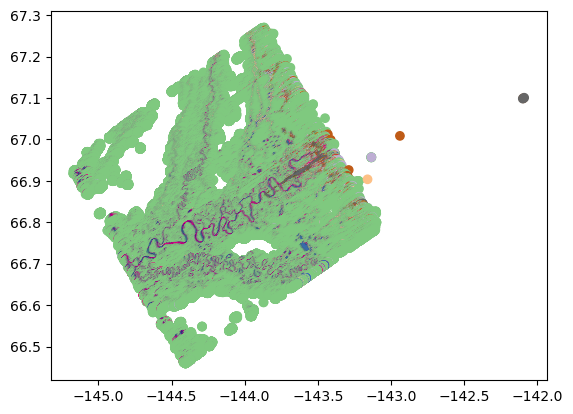

In [8]:
plt.scatter(x=ds_PIXC.longitude, y=ds_PIXC.latitude, c=ds_PIXC.classification, cmap='Accent')
# plt.clim((0,100))
# plt.colorbar().set_label('Height (m)')

### Make unfiltered geopckgs

In [49]:
def makeGDFnon(ds, data_var):
    # This function takes the pixel cloud, makes a GeoDataFrame,
    # renames columns as needed, projects the CRS, and returns
    # the GDF 

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(data=ds[data_var],
                                geometry=gpd.points_from_xy(
                                    ds.longitude,
                                    ds.latitude),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if data_var == 'classification':
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    else:
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: data_var}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    return gdf_PIXC

In [27]:
# Set up
data_path = '/nas/cee-water/cjgleason/SWOTdata/PIXC_v2_0_090324/yukon_ohio_test_tiles_nc/'
save_path = '/nas/cee-water/cjgleason/SWOTdata/PIXC_v2_0_090324/yukon_ohio_test_tiles_gpkg/'

In [30]:
# Get all granules
files = listdir(join(data_path))

# Remove hidden folders from list
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
# files

In [52]:
for file in files:
    ds_PIXC = xr.open_mfdataset(paths=join(data_path, file), group='pixel_cloud', engine='h5netcdf')
    # data_vars = list(ds_PIXC.data_vars)

    # Make PIXC, specify data variable
    gdf_PIXC = makeGDFnon(ds=ds_PIXC, data_var='classification')

    # Write out file
    gdf_PIXC.to_file(os.path.join(save_path, file + '_klass.gpkg'), driver='GPKG')

### Make filtered geopckgs

In [11]:
def bitwiseMask(ds):
    # Fow now, eliminate the really bad stuff
    mask = np.where(np.logical_and(ds.classification > 1, ds.geolocation_qual < 2**12))[0]
    print(mask.shape)
    return mask

In [12]:
def makeGDF(ds, mask, data_var):
    # This function takes the pixel cloud, makes a GeoDataFrame,
    # renames columns as needed, projects the CRS, and returns
    # the GDF 

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(ds[data_var][mask],
                                geometry=gpd.points_from_xy(
                                    ds.longitude[mask],
                                    ds.latitude[mask]),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if data_var == 'classification':
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    else:
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: data_var}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    return gdf_PIXC

In [13]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths='/nas/cee-water/cjgleason/SWOTdata/one_off_randos_v2_0/SWOT_L2_HR_PIXC_020_024_034R_20240821T113904_20240821T113915_PIC0_01.nc',
                            group = 'pixel_cloud', engine='h5netcdf')

In [14]:
# Make mask
mask = bitwiseMask(ds=ds_PIXC)

(674095,)


In [15]:
# If dataframe not empty after filtering
if mask.shape != (0,):
    # Make PIXC, specify data variable
    gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_var='classification')

    # Write out file
    # gdf_PIXC.to_file(os.path.join(save_path, file + '_filtered_klass.gpkg'), driver='GPKG')

#### Plot

In [24]:
# Make dict for legend labels
flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [16]:
# Make color palette
palette = {2: 'darkkhaki', 3: 'cornflowerblue', 4: 'blue', 5: 'hotpink',
           6: 'lightsalmon', 7: 'lightblue'}

In [29]:
# Get labels for plot
nums = list(np.unique(gdf_PIXC.klass).astype('int'))
labels = [codes[x] for x in nums]

# Make cmap
cmap = colors.ListedColormap([palette[x] for x in nums])

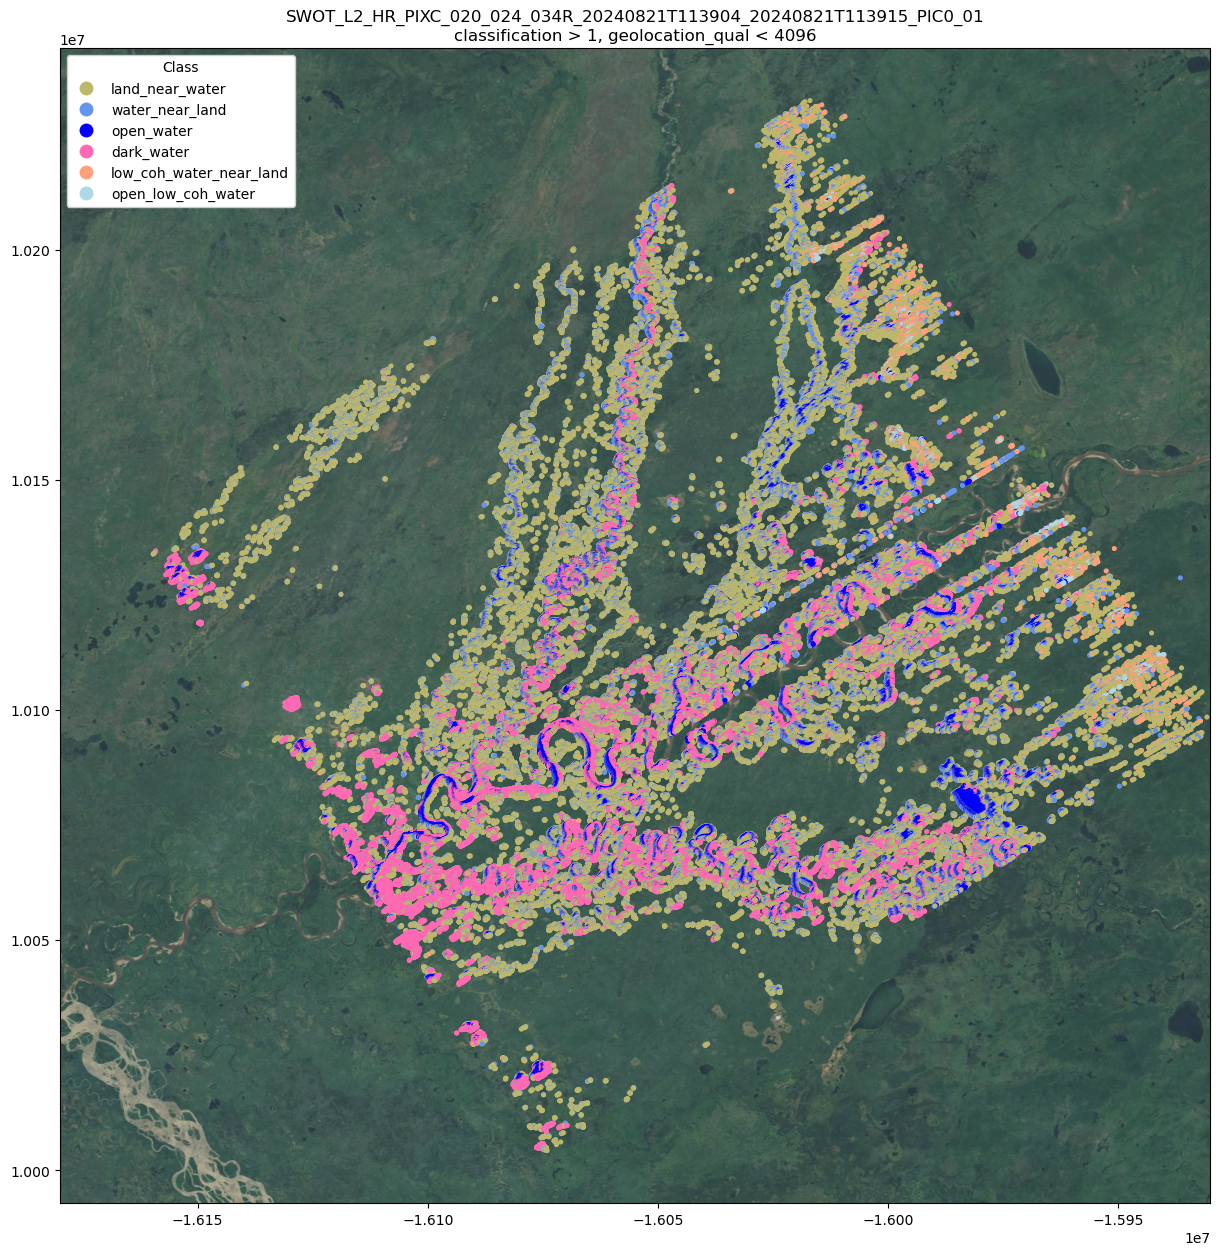

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(15,15))

gdf_PIXC.plot(column=gdf_PIXC.klass, categorical=True, 
            markersize=7, cmap=cmap, legend=True,
            legend_kwds={'labels': labels,
                         'framealpha': 1, 
                         'title_fontsize': 'medium',
                         'loc': 'upper left'},
            ax=ax)

plt.xlim(-16180000,-15930000)

# Basemap
# Sentinel 2 basemap
s2 = 'https://tiles.maps.eox.at/wmts/1.0.0/s2cloudless-2018_3857/default/g/{z}/{y}/{x}.jpg'
cx.add_basemap(ax, crs=gdf_PIXC.crs, source=s2, alpha=0.9, zoom=10)
# cx.add_basemap(ax, crs=gdf_PIXC.crs, source=cx.providers.CartoDB.DarkMatter, alpha=0.9)

# Legend
leg = ax.get_legend()
leg.set_title("Class")          

# Save plot
plt.title('SWOT_L2_HR_PIXC_020_024_034R_20240821T113904_20240821T113915_PIC0_01\nclassification > 1, geolocation_qual < 4096')
plt.savefig('porcupine_08_21_2024.png', bbox_inches='tight')

In [32]:
pwd

'/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC'